### Overview

This article will explore how you can use company fundamentals and estimates data to conduct a discounted cashflow (DCF) type intrinsic valuation for a company and its peers to provide a relative valuation overlay. We also use some unsupervised ML routines to generate classification groupings for our data.  

Company Fundamentals is our new strategic content set, with the most comprehensive, accurate and timely data on public and private companies around the world.  It aims to provide both company specific data disclosed by the company and also standardized data to enhance the comparability of the financial data of companies from different countries, accounting standards and industries. This is a very large content set that combines the best of Fundamentals and also Worldscope. On average it provides 60% more content than the previous  Fundamentals content set.  

We will also look at our extensive Estimates content and will go on to use this data in a popular intrinsic valuation example - Discounted Cashflow. We will then extend this out to peer companies to see what that could yield - looking at some popular unsupervised methods of clustering, KMeans and Gaussian Mixure Models. 

**Sections**

[Fundamental Data](#fun)

[Estimates Data](#est)

[Discounted Cashflow](#dcf)

[Peer Group Comparison](#peers)

[Relative Valuation](#rv)

[Clustering](#clustering)

[Summary](#summary)

**Pre-requisites:**

**LSEG Workspace** with access to [LSEG Data Library for Python](https://developers.lseg.com/en/api-catalog/lseg-data-platform/lseg-data-library-for-python) (Free Trial Available)

Python 3.x

Required Python Packages: [lseg-data](https://pypi.org/project/lseg-data/), [pandas](https://pypi.org/project/pandas/), [numpy](https://pypi.org/project/numpy/), [sci-kit Learn](https://pypi.org/project/scikit-learn/), [numpy-financial](https://pypi.org/project/numpy-financial/),

<a id='fun'></a>
###  Fundamental data

Here we will import the libraries we need and st our authorisation using our App Key. We will then simply download full income statement, cashflow statement and balance sheet. This is a vastly improved workflow as we can now request the whole template as one field.

In [1]:
import lseg.data as ld
import numpy as np
from numpy import where
from numpy import unique
import numpy_financial as npf
import pandas as pd
from sklearn.cluster import KMeans
from sklearn.mixture import GaussianMixture
from sklearn.linear_model import LinearRegression
import pylab as plt
import warnings

%matplotlib inline
plt.style.use("seaborn-v0_8")
warnings.filterwarnings("ignore")

ld.open_session(app_key = '<APP KEY>')

<lseg.data.session.Definition object at 0x1fb0b018080 {name='workspace'}>

#### Income Statement




In [2]:
df = ld.get_data(
    universe = ['VOD.L'],
    fields = ['TR.F.IncomeStatement.fieldname','TR.F.IncomeStatement.fielddescription','TR.F.IncomeStatement'],
    parameters = {'Period': 'FY0','reportingState':'Rsdt', 'curn':'Native', 'Scale':'6','SORTA':'LISeq'})

df

,Instrument,Name,Description,STD Income Statement All
0,VOD.L,TR.F.RevGoodsSrvc,Revenue from Goods & Services [SNTS] represent...,30758.0
1,VOD.L,TR.F.SalesOfGoodsSrvcNetUnclassif,Sales of Goods & Services - Net - Unclassified...,30758.0
2,VOD.L,TR.F.RevBizRelActivOthTot,Revenue from Business-Related Activities - Oth...,6690.0
3,VOD.L,TR.F.TotRevenue,Revenue from Business Activities - Total [STLR...,37448.0
4,VOD.L,TR.F.CostOfOpRev,Cost of Operating Revenue [SCOR] represents th...,24929.0
...,...,...,...,...
163,VOD.L,TR.F.DPSComGrossIssueByPrdEndDate,DPS - Common - Gross - Issue - By Period End D...,0.0
164,VOD.L,TR.F.OpExpnExclNonCashChrgTot,Operating Expenses excluding Non-Cash Charges ...,21626.0
165,VOD.L,TR.F.IncAvailToComShrBefDeprAmort,Income Available to Common Shares before Depre...,6635.0
166,VOD.L,TR.F.FixedChrg,Fixed Charges [SFXC] represents the sum of Int...,2541.0


#### Cashflow Statement


In [4]:
df1 = ld.get_data(
    universe = ['VOD.L'],
    fields = ['TR.F.CashflowStatement.fieldname','TR.F.CashflowStatement.fielddescription','TR.F.CashflowStatement'],
    parameters = {'Period': 'FY0','reportingState':'Rsdt', 'curn':'Native', 'Scale':'6','SORTA':'LISeq'})
df1

,Instrument,Name,Description,STD Cash Flow All
0,VOD.L,TR.F.ProfLossStartingLineCF,Profit/(Loss) - Starting Line - Cash Flow [SPL...,-3746
1,VOD.L,TR.F.NonCashItemsReconcAdjCF,Non-cash Items & Reconciliation Adjustments - ...,18293
2,VOD.L,TR.F.DiscOpsGLNetOfTaxCF,Discontinued Operations - Gain/(Loss) - Net of...,22
3,VOD.L,TR.F.EqIncLossInNetEarnCF,Equity Income/(Loss) in Net Earnings - Cash Fl...,123
4,VOD.L,TR.F.IncTaxExpnCF,Income Tax Expense - Cash Flow - to Reconcile ...,2246
...,...,...,...,...
68,VOD.L,TR.F.ComStockBuybackNet,Common Stock Buyback - Net [SCSBN] represents ...,1865
69,VOD.L,TR.F.DeprDeplAmortCF,"Depreciation, Depletion & Amortization - Cash ...",10804
70,VOD.L,TR.F.FreeCashFlowToEq,Free Cash Flow to Equity [SFCFE] represents th...,-3328
71,VOD.L,TR.F.FOCF,Free Cash Flow Net of Dividends [SFCFO] repres...,3081


#### Balance Sheet



In [5]:

df2 = ld.get_data(
    universe = ['VOD.L'],
    fields = ['TR.F.BalanceSheet.fieldname','TR.F.BalanceSheet.fielddescription','TR.F.BalanceSheet'],
    parameters = {'Period': 'FY0','reportingState':'Rsdt', 'curn':'Native', 'Scale':'6','SORTA':'LISeq'})
df2

,Instrument,Name,Description,STD Balance Sheet All
0,VOD.L,TR.F.CashSTInvst,Cash & Short Term Investments [SCSI] refers to...,18425.0
1,VOD.L,TR.F.CashCashEquiv,Cash & Cash Equivalents [SCAE] represents shor...,4470.0
2,VOD.L,TR.F.STInvstTot,Short-Term Investments - Total [SSTI] represen...,13955.0
3,VOD.L,TR.F.DerivFinInstrHedgeST,Derivative Financial Instruments - Hedging - S...,133.0
4,VOD.L,TR.F.LoansRcvblNetST,Loans & Receivables - Net - Short-Term [SCLR] ...,8739.0
...,...,...,...,...
196,VOD.L,TR.F.TradeAcctTradeNotesRcvblNetTot,Trade Accounts & Trade Notes Receivable - Net ...,3745.0
197,VOD.L,TR.F.CurrLiabExclCurrDebtTot,Current Liabilities excluding Current Debt - T...,15707.0
198,VOD.L,TR.F.CurrAssetsExclCashSTInvstTot,Current Assets excluding Cash & Short Term Inv...,10195.0
199,VOD.L,TR.F.CashSTInvstAcctRcvblTot,"Cash, Short Term Investments & Accounts Receiv...",22170.0


<a id='est'></a>
### Estimates Data

Workspace carries 260+ types of estimate related to company financials. These are critical for measuring future performance, risk and valuation of companies. Both analysts and investors closely follow these. Statistically speaking, the accuracy of estimates for longer time frames are subject to increasing error and longer term guidance is generally less reliable than shorter timeframes.

#### Company Estimates
Each year the company itself provides its own forward-looking guidance by way of releasing forecasts for interim & full year(s) ahead. They update this guidance periodically when the outlook has some material change. They can do this formally for example in earnings releases or mention something materially important in an interview or Q&A session. We capture this information and provide this to you in an easy to consume format - including the source of the guidance. 

In [8]:
 
df3 = ld.get_data(
    universe = ['VOD.L'],
    fields = ['TR.GuidanceMeasure','TR.EstGuidHighValue','TR.EstGuidLowValue','TR.GuidanceText'],
    parameters =  {'Period':'FY1,FY2','GuidMeasure':'REV,EBIT,EBITDA','GuidDataBasis':'VAL'})

df3

,Instrument,Guidance Measure,Guidance High Value,Guidance Low Value,Guidance Text
0,VOD.L,EBITDA,11000000000,11000000000,"As far as the UK merger is concerned, we expec..."
1,VOD.L,EBITDA,<NA>,<NA>,"Within this, we are targeting between EUR7.2 b..."
2,VOD.L,Revenue,<NA>,<NA>,I am confident that the actions we are taking ...
3,VOD.L,Revenue,<NA>,<NA>,"And of course, this will reflect, as Luka was ..."
4,VOD.L,EBIT,<NA>,<NA>,"Looking ahead, we expect to see broad-based mo..."
5,VOD.L,EBITDA,<NA>,<NA>,"And then, of course, as the on-boarding is com..."
6,VOD.L,EBITDA,<NA>,<NA>,- FY25 guidance achieved: Adjusted EBITDAaL of...
7,VOD.L,EBITDA,<NA>,<NA>,"And we will continue, frankly, to invest into ..."
8,VOD.L,EBITDA,<NA>,<NA>,-€0.2 billion dilutive to Adjusted Free Cash F...


#### Analyst Estimates
Companies - generally depending on their size - are also followed by analysts in banks who themselves make forecasts for the companies they follow - and also usually some sort of recommendation eg Buy, Sell, Hold and a price target. Now for large companies - where there are lots of analysts covering them - there are likely to be more updates to these figures. This is good as one can usually find a more recent update than for company guidance. In more recent times the list of forecasted items has been expanded to include many more items than the basic ones and include some cashflow and balance sheet related items as well. We also provide expanded coverage of particular industry-specific metrics which allow for deeper dives into relevant industry sectors - see the image below: 

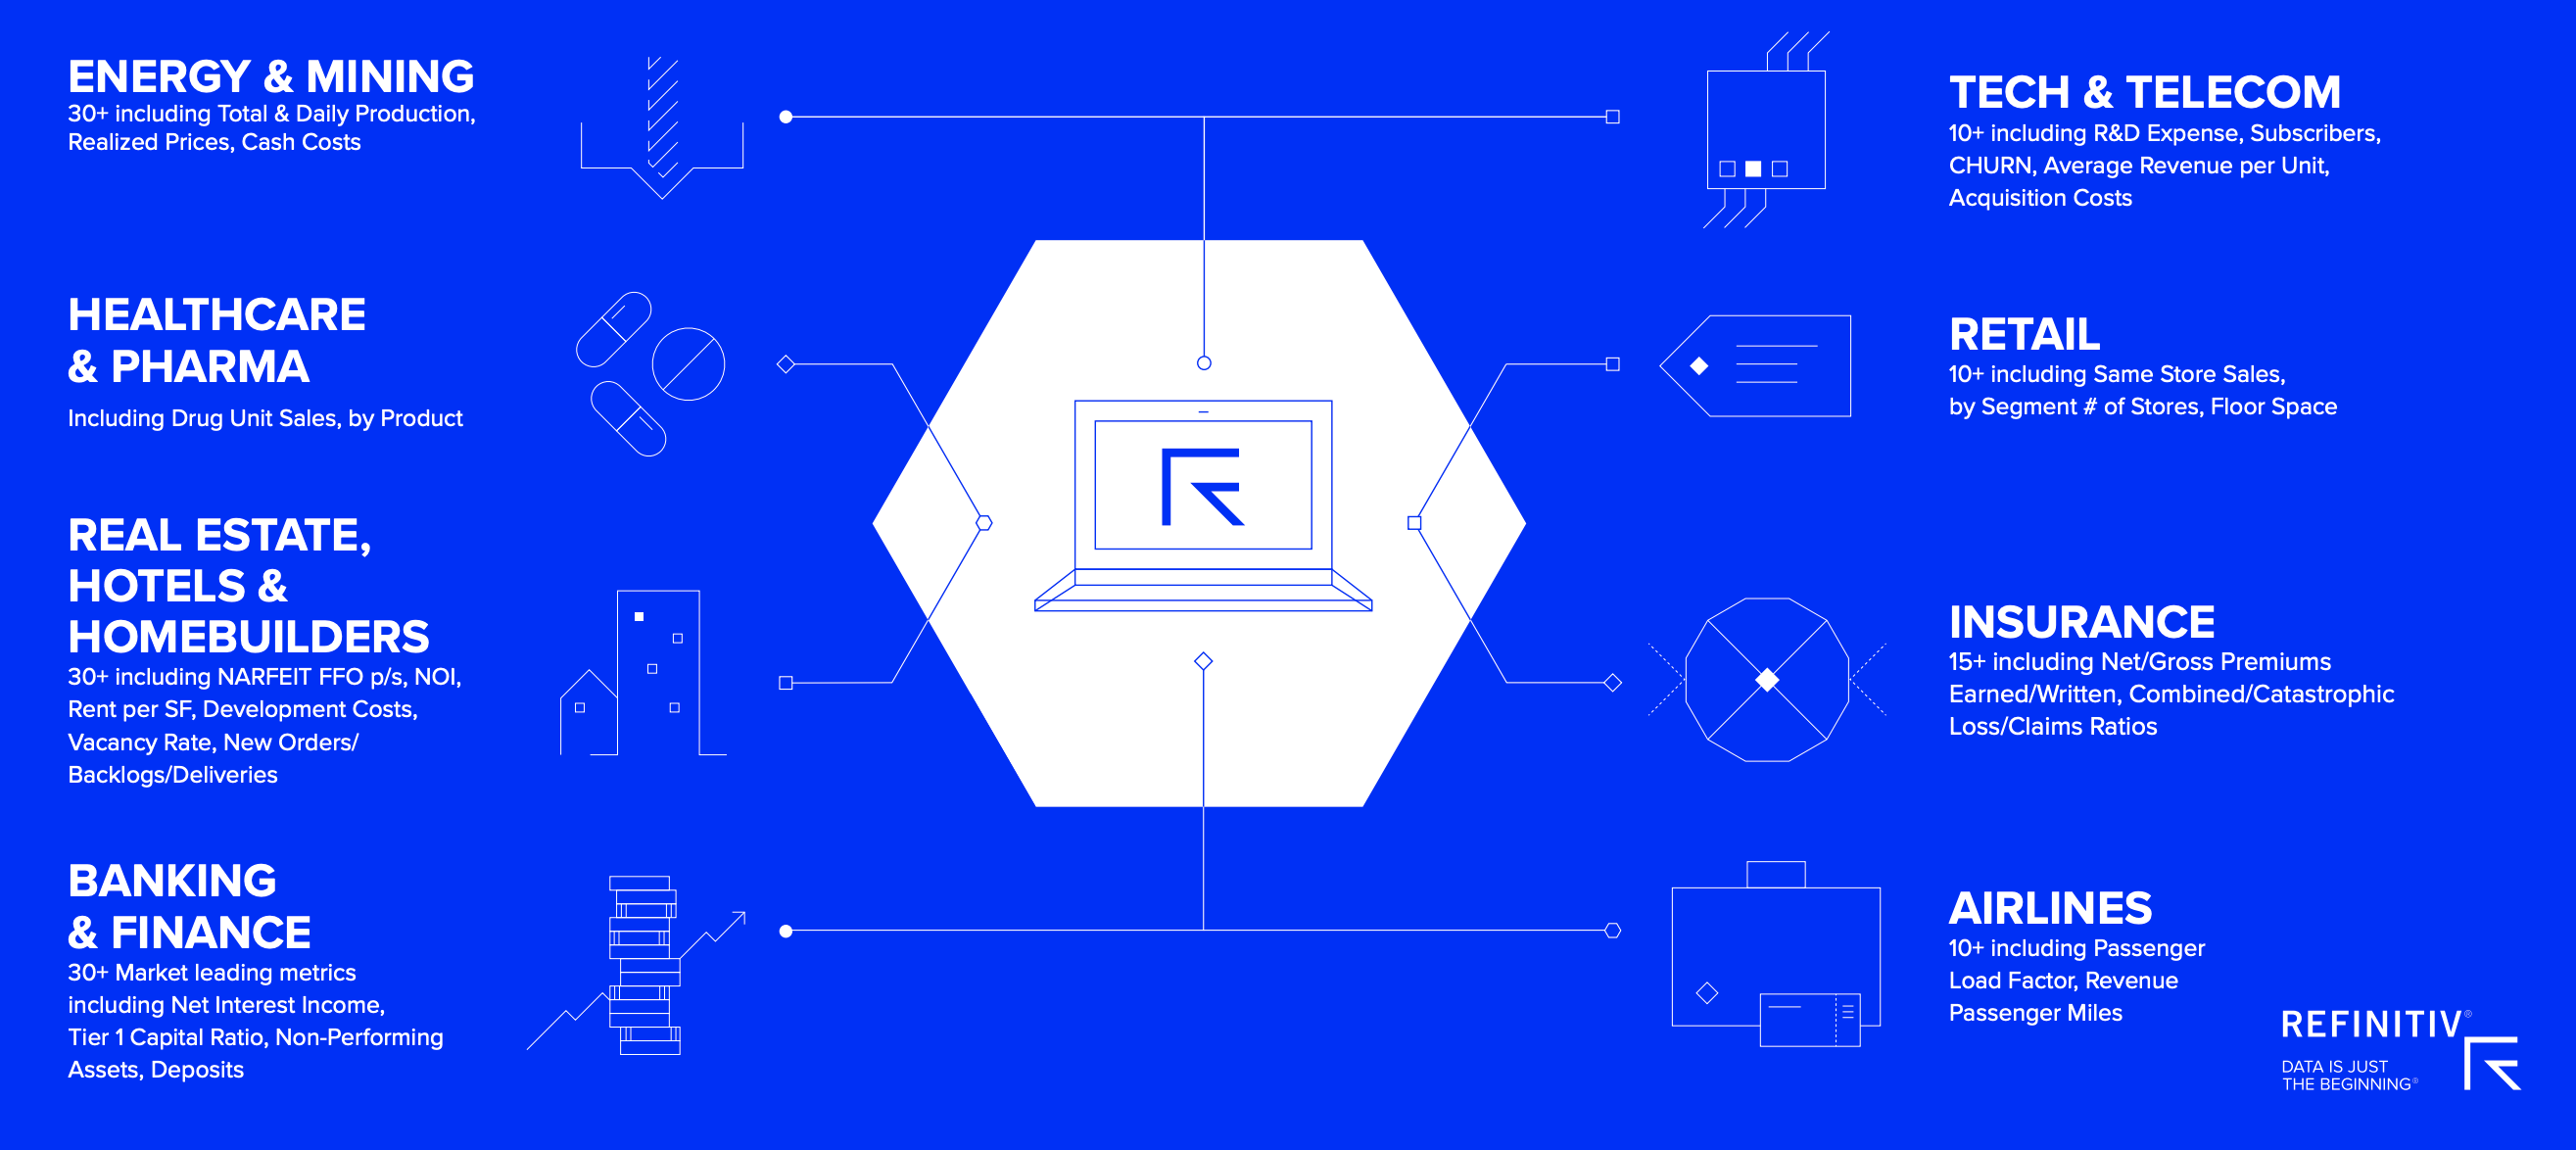

So lets have a look at how we can get individual analyst estimates for a stock - here we just look at Revenue.

In [10]:

df4 = ld.get_data(
    universe = ['VOD.L'],
    fields = ['TR.RevenueEstValue(Period=FY1).date',
              'TR.RevenueEstValue(Period=FY1).brokername',
              'TR.RevenueEstValue(Period=FY1).analystname',
              'TR.RevenueEstValue(Period=FY1).analystcode',
              'TR.RevenueEstValue(Period=FY1)'])
                      
df4

,Instrument,Date,Broker Name,Analyst Name,Analyst Code,Revenue - Broker Estimate
0,VOD.L,2025-05-13 00:19:00,DEUTSCHE BANK,"Grindle, Robert",4AIT,37770000000
1,VOD.L,2025-05-09 18:35:00,GOLDMAN SACHS,"Lee, Andrew",FG3,37765777000
2,VOD.L,2023-11-08 10:13:00,ROTHSCHILD & CO REDBURN,"Malcolm, Steve",7R4V,43618230000
3,VOD.L,2025-05-20 08:16:00,JPMORGAN,"Dattani, Akhil",3MBD,37700000000
4,VOD.L,2025-06-24 05:49:00,CITI,"Murdock Smith, Carl",90N3,41209310000
5,VOD.L,2025-06-16 04:00:00,UBS,"Tang, Polo",4Y98,41616207000
6,VOD.L,2024-07-29 06:45:00,LANDESBANK BADEN-WUERTTEMBERG,"Deuscher, Bettina",4O3B,37702000000
7,VOD.L,2025-02-04 13:43:00,"MORNINGSTAR, INC.","Correonero, Javier",7WZ3,37489000000
8,VOD.L,2025-03-14 08:37:00,ARETE RESEARCH,"Pound, Alex",8ESA,42400000000
9,VOD.L,2025-05-20 20:11:00,NEXTGEN RESEARCH LTD,"Funnell, Justin",87UJ,40848000000


And lets now look at how we can get some of these expanded industry metrics - this time for Tech and Telecom - using Verizon. Note these expanded metrics will not be available for all geographies.

In [11]:

df5 = ld.get_data(
    universe = ['VZ'],
    fields = ['TR.Subscribers','TR.SubscribersBrokerName',
              'TR.NetSubscriberAdds','TR.NetSubscriberAddsBrokerName',
              'TR.AvgRevPerUnitEstValue','TR.AvgRevPerUnitEstBrokerName',
              'TR.ChurnpctEstValue','TR.ChurnpctEstBrokerName'],
    parameters = {'Period':'FY1','SDate':'-200','EDate':'0','Frq':'D'})

df5

,Instrument,No. Of Subscribers / Users - Broker Estimate,Broker Name,Net Subscriber Additions - Broker Estimate,Broker Name,Avg Revenue Per Unit / User - Broker Estimate,Broker Name,Churn Percentage - Broker Estimate,Broker Name
0,VZ,148924000,JPMORGAN,2300000,"OPPENHEIMER & CO., INC.",45.6,DEUTSCHE BANK,<NA>,JPMORGAN
1,VZ,<NA>,"OPPENHEIMER & CO., INC.",2926000,DEUTSCHE BANK,44.15,"OPPENHEIMER & CO., INC.",1.59,RBC CAPITAL MARKETS
2,VZ,148661000,MOFFETTNATHANSON,3015000,"WELLS FARGO SECURITIES, LLC",43.1,MOFFETTNATHANSON,1.11,"OPPENHEIMER & CO., INC."
3,VZ,148924000,JPMORGAN,1117000,RBC CAPITAL MARKETS,45.6,DEUTSCHE BANK,1.14,"WELLS FARGO SECURITIES, LLC"
4,VZ,148661000,MOFFETTNATHANSON,1200000,JPMORGAN,43.1,MOFFETTNATHANSON,1.18,DEUTSCHE BANK
...,...,...,...,...,...,...,...,...,...
1201,VZ,<NA>,,<NA>,,<NA>,,1.51,RBC CAPITAL MARKETS
1202,VZ,<NA>,,<NA>,,<NA>,,1.56,MOFFETTNATHANSON
1203,VZ,<NA>,,<NA>,,<NA>,,1.1,JPMORGAN
1204,VZ,<NA>,,<NA>,,<NA>,,1.16,"WELLS FARGO SECURITIES, LLC"


#### Consensus Estimates
As with all ranges of opinion - some analysts are more positive than others - so consensus estimates have developed - whose role is to try to capture the mean of all analysts who are covering the company. Our I/B/E/S (Institutional Brokers Estimates System) is the industry standard, founded in 1976, offering coverage for 22,000 active companies across 90 countries from over 18,000 analysts. Above we mentioned that not all analysts will necessarily report on all measures - so the number of estimates for some of these measures maybe lower than for the most common ones. Additionally - some estimates are not included due to staleness etc. Hence the importance of incorporating # of included estimates as a guide for usefulness of the estimate. One can also get an idea of how varied estimates are by including Estimate High, Low and Median - I haven't included them here but they are all available by searching the Data Item Browser or Code Creator apps on the desktop.

The really great thing here is that we can track these on a daily basis to see realtime changes in expectations for these core metrics. For example if one analyst changes their estimate it will be reflected in the mean. Very often we see clusters of changes together (herding) so the mean expectation can adjust quite rapidly to a new level - in other cases it can take a while. Here we look at these for the last 200 days. To see the impact on shareprice of VOD.L - it is easy just to add a closing shareprice for the last 200 days. 

In [13]:
                      
df6 = ld.get_data(
    universe = ['VOD.L'],
    fields = ['TR.RevenueMean(Period=FY1).calcdate',
              'TR.RevenueMean(Period=FY1)',
              'TR.RevenueNumIncEstimates(Period=FY1)',
              'TR.GrossIncomeMean(Period=FY1)',
              'TR.GrossIncomeNumIncEstimates(Period=FY1)',
              'TR.PreTaxProfitMean(Period=FY1)',
              'TR.PreTaxProfitNumIncEstimates(Period=FY1)',
              'TR.NetProfitMean(Period=FY1)',
              'TR.NetProfitNumIncEstimates(Period=FY1)',
              'TR.EPSMean(Period=FY1)',
              'TR.EPSNumIncEstimates(Period=FY1)',
              'TR.DPSMean(Period=FY1)',
              'TR.DPSNumIncEstimates(Period=FY1)',
              'TR.CLOSEPRICE(Adjusted=1)'],
    parameters =  {'SDate':'-2000','EDate':'0', 'Frq':'D'})

df6.index = pd.to_datetime(df6['Calc Date'])
df6

,Instrument,Calc Date,Revenue - Mean,Revenue - Number of Included Estimates,Gross Income - Mean,Gross Income - Number of Included Estimates,Pre-Tax Profit - Mean,Pre-Tax Profit - Number of Included Estimates,Net Income - Mean,Net Income - Number of Included Estimates,Earnings Per Share - Mean,Earnings Per Share - Number of Included Estimates,Dividend Per Share - Mean,Dividend Per Share - Number of Included Estimates,Close Price
Calc Date,,,,,,,,,,,,,,,
2017-07-31,VOD.L,2017-07-31,47721835510,24,20682000000,2,3334940060,16,2361390670,18,0.08747,23,0.14288,23,222.0
2017-08-01,VOD.L,2017-08-01,47721835510,24,20682000000,2,3334940060,16,2361390670,18,0.08747,23,0.14288,23,221.65
2017-08-02,VOD.L,2017-08-02,47721835510,24,20682000000,2,3334940060,16,2361390670,18,0.08747,23,0.14288,23,220.75
2017-08-03,VOD.L,2017-08-03,47721835510,24,20682000000,2,3334940060,16,2361390670,18,0.08747,23,0.14288,23,224.0
2017-08-04,VOD.L,2017-08-04,47721835510,24,20682000000,2,3334940060,16,2361390670,18,0.08747,23,0.14288,23,225.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2025-06-26,VOD.L,2025-06-26,39058068310,16,11691000000,2,3021940310,13,2034114860,14,0.08171,14,0.05077,17,77.64
2025-06-27,VOD.L,2025-06-27,39058068310,16,11691000000,2,3021940310,13,2034114860,14,0.08171,14,0.05077,17,77.54
2025-06-30,VOD.L,2025-06-30,39060880810,16,11691000000,2,3035786460,13,1971614860,14,0.08207,14,0.05077,17,77.78


It is then really simple to visual any of these components impacts on sharerpice - lets do it graphically and then numerically (in this case we will just use a straightforward Pearsons correlation coefficient - but you may need to make the series stationary then calculate the correlation. Generally, over longer periods financial timeseries - particularly shareprices - display non-stationarity).

array([<Axes: xlabel='Calc Date'>, <Axes: xlabel='Calc Date'>],
      dtype=object)

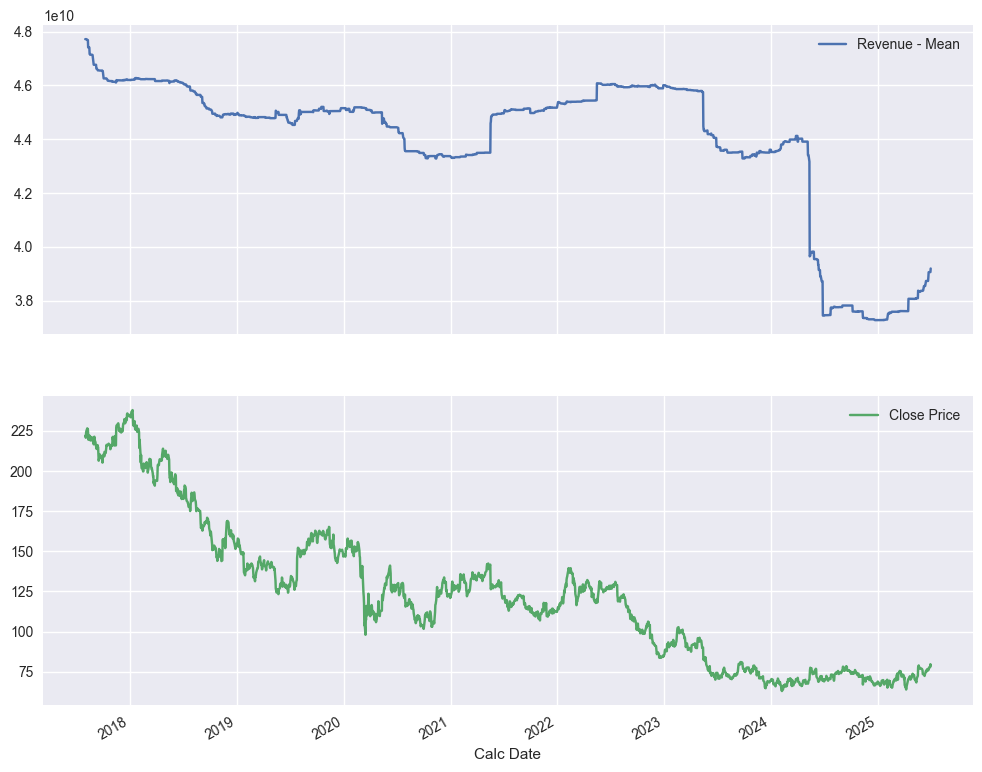

In [14]:
df6[['Revenue - Mean','Close Price']].plot(subplots=True, figsize=(12,10))

In [15]:
df6[['Revenue - Mean','Close Price']].corr()

,Revenue - Mean,Close Price
Revenue - Mean,1.000000,0.624967
Close Price,0.624967,1.000000


#### Starmine Smart Estimates
Our Starmine Estimates go a step further by trying to weight more successful (in terms of accuracy) analysts opinions more highly - similarly penalising less accurate analysts. More weight is also allocated to more recent updates whilst those that are stale ie quite old - are dropped completely from the Starmine Smart Estimates. In this way we try to capture a more reliable and timely picture. There have been lots of papers written on the validity and transparency of Starmne Smart Estimates over the years. Please see the links for further information about methodology and results. Again I have used a convenient selection but many more fields are available.

In [16]:

df7 = ld.get_data(
    universe = ['VOD.L'],
    fields = ['TR.RevenueMean(Period=FY1).date',
              'TR.RevenueSmartEst(Period=FY1)',
              'TR.RevenueSENumIncEst(Period=FY1)',
              'TR.GrossIncomeSmartEst(Period=FY1)',
              'TR.GrossIncomeSENumIncEst(Period=FY1)',
              'TR.PreTaxProfitSmartEst(Period=FY1)',
              'TR.PreTaxProfitSENumIncEst(Period=FY1)',
              'TR.NetprofitSmartEst(Period=FY1)',
              'TR.NetProfitSENumIncEst(Period=FY1)',
              'TR.EpsSmartEst(Period=FY1)',
              'TR.EpsSENumIncEst(Period=FY1)',
              'TR.DPSSmartEst(Period=FY1)',
              'TR.DPSSENumIncEst(Period=FY1)',
              'TR.CLOSEPRICE(Adjusted=1)'],
    parameters = {'SDate':'-200','EDate':'0'})
                      
df7.index = pd.to_datetime(df7['Date'])
df7

,Instrument,Date,Revenue - SmartEstimate®,Revenue - SmartEstimate Num of Included Estimates,Gross Income - SmartEstimate®,Gross Income - SENum Inc Ests,Pre-Tax Profit - SmartEstimate®,Pre-Tax Profit - SmartEstimate Num of Included Estimates,Net Income - SmartEstimate®,Net Income - SmarteEstimate Num of Included Estimates,Earnings Per Share - SmartEstimate®,Earnings Per Share - SmartEstimate Num of Included Estimates,Dividend Per Share - SmartEstimate®,Dividend Per Share - SmartEstimate Num of Included Estimates,Close Price
Date,,,,,,,,,,,,,,,
2024-09-03,VOD.L,2024-09-03,37296622960,10,<NA>,<NA>,3021020330,12,2171974910,13,0.08228,11,0.04943,9,78.42
2024-09-03,VOD.L,2024-09-03,37296622960,10,<NA>,<NA>,3021020330,12,2171974910,13,0.08628,10,0.04943,9,77.62
2024-09-03,VOD.L,2024-09-03,37296622960,10,<NA>,<NA>,3032692380,12,2171974910,13,0.08628,10,0.04943,9,78.08
2024-09-03,VOD.L,2024-09-03,37296622960,10,<NA>,<NA>,3032692380,12,2171974910,13,0.08628,10,0.04943,9,76.16
2024-09-03,VOD.L,2024-09-03,37296622960,10,<NA>,<NA>,3032692380,12,2171974910,13,0.08628,10,0.04943,9,75.56
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2025-06-25,VOD.L,2025-06-25,39668076810,11,11011000000,1,2997897660,11,1985944340,10,0.08061,7,0.04857,6,77.64
2025-06-25,VOD.L,2025-06-25,39668076810,11,11011000000,1,2997897660,11,1985944340,10,0.08061,7,0.04857,6,77.54
2025-06-30,VOD.L,2025-06-30,39673841050,11,11011000000,1,3030766460,11,1877634450,10,0.08199,7,0.04857,6,77.78


array([<Axes: xlabel='Date'>, <Axes: xlabel='Date'>], dtype=object)

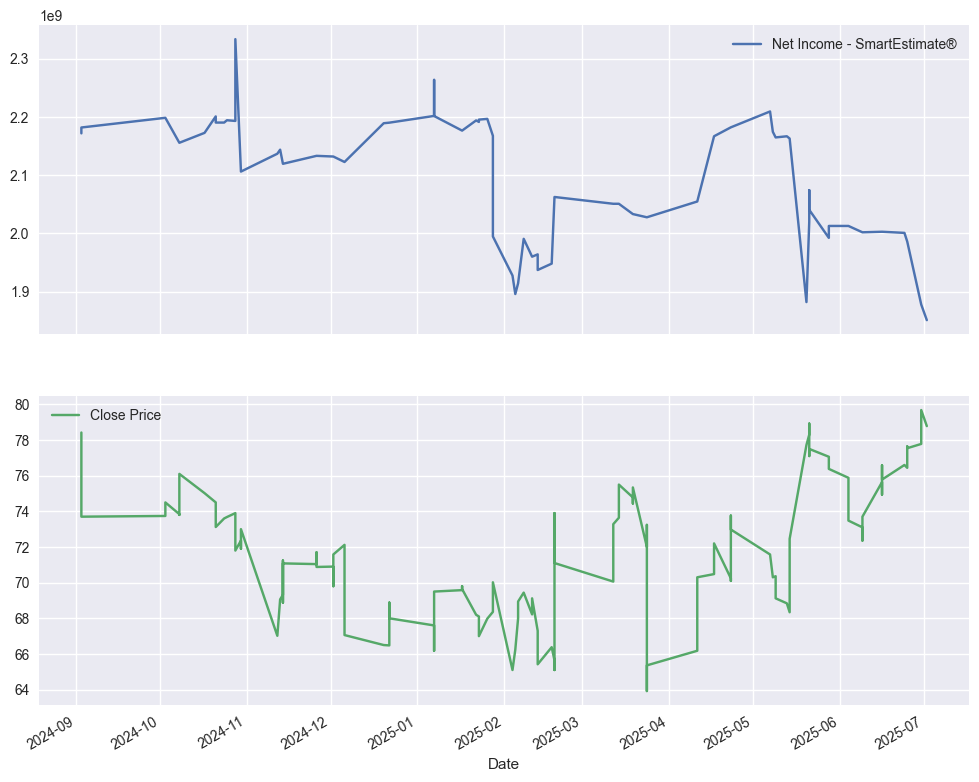

In [17]:
df7[['Net Income - SmartEstimate®','Close Price']].plot(subplots=True,figsize=(12,10))

In [18]:
df7[['Net Income - SmartEstimate®','Close Price']].corr()

,Net Income - SmartEstimate®,Close Price
Net Income - SmartEstimate®,1.000000,-0.134208
Close Price,-0.134208,1.000000


<a id='dcf'></a>
### Discounted Cashflow

We will now look at how to implement this popular approach to valuation. There are many ways to approach this sort of task - as evidenced by the number of books on the subject. The approach I am using here does not require us to forecast free cashflow - rather we use IBES consensus estimates for these. Typically these forecasts go out 4 years or so. So we can use these for our forecasted period. After this period forecasting becomes more challenging - but the company will likely generate more cashflows after the end of our 4 year forecast window. To capture this we will generate what is known as a terminal value for cashflow - based on an exit multiple. We take the most recent EV / Free Cash Flow multiple and then assign that to our last forecasted cashflow number. So lets see how we can do this. 

First we will get some selected fields that we need to help us with our calculation. 

In [19]:

df8 = ld.get_data(
    universe = ['VOD.L'],
    fields = ['TR.F.DebtTot','TR.WACC','TR.F.ComShrOutsTot(Period=FY0)', 'TR.EVtoFCFSmartEst(Period=FY1)'])
df8

,Instrument,Debt - Total,"Weighted Average Cost of Capital, (%)",Common Shares - Outstanding - Total,EV / Free Cash Flow (SmartEstimate ®)
0,VOD.L,53143000000,5.604938,24965472590,38.074851


Next we will get our IBES consensus free cashflow forecasts going out 4 fiscal years. I also include the most recent actual value at the start. 

In [20]:
fcf = ld.get_data(
    universe = ['VOD.L'],
    fields = ['TR.FCFMean(Period=FY0)','TR.FCFMean(Period=FY1)','TR.FCFMean(Period=FY2)',
              'TR.FCFMean(Period=FY3)','TR.FCFMean(Period=FY4)'])

fcf.columns =['RIC','FCF-FY0','FCF-FY1','FCF-FY2','FCF-FY3','FCF-FY4']
fcf

,RIC,FCF-FY0,FCF-FY1,FCF-FY2,FCF-FY3,FCF-FY4
0,VOD.L,5379956590,2007079360,2591870420,2701021980,2812203340


Next we want to calculate the net present value of these cashflows using WACC as the discount rate. Here we simply use the numpy net present value function.

In [21]:
dfcf = npf.npv(df8['Weighted Average Cost of Capital, (%)'].values,fcf.iloc[0,2:5].values.tolist())
dfcf

2461407689.9551463

Now we want to calculate our terminal value using the exit multiple we identified - in this case Enterprise Value / Free Cashflow multiple, and apply this to the last Free Cashflow forecast (FY4).

In [22]:
tv_exit = df8['EV / Free Cash Flow (SmartEstimate ®)'] * fcf.iloc[0][5]
tv_exit

0    107074223858.768433
Name: EV / Free Cash Flow (SmartEstimate ®), dtype: Float64

Now we are getting to the final stages of our valuation. We now set our flow value to be the sum of our discounted cashflow plus our terminal value. 

In [23]:
flo_val = dfcf + tv_exit
flo_val

0    109535631548.723572
Name: EV / Free Cash Flow (SmartEstimate ®), dtype: Float64

We need to subtract the debt portion from the enterprise value so we our left with our Equity portion - which we can then divide by shares outstanding to get our valuation per share.

In [24]:
model_price = (flo_val - df8['Debt - Total'])/ df8['Common Shares - Outstanding - Total']
model_price

0    2.258825
dtype: Float64

As this is a UK share we need to multiply the equity value (which is in pounds) to pence so we can compare it to the quoted shareprice.

In [25]:
model_price*100

0    225.882492
dtype: Float64

Now we can just compare it to the most recent closing price.

In [26]:
df9 = ld.get_data('VOD.L','CF_CLOSE')
df9

,Instrument,CF_CLOSE
0,VOD.L,78.78


<a id='peers'></a>
### Peer Group Comparison

The LSEG Data Library provides a really convenient Peers function which allows you to retrieve a list of peer RICs for any company RIC you enter. The peers are global in scope and allow one to perform quite nice relative valuation or competitor analysis. In our case we will simply replicate our previous DCF analysis across the peer companies of Vodafone. You can of course replace this with metrics such as PER, PCF, PTS, EV/EBITDA, Dividend Yield etc. 

In the case of VOD.L we had all the numbers we needed and all the calculations worked fine - however, as we will see this may not always be the case. All expected forecasts may not be present or other data maybe NaN or missing. So dealing with these kinds of exceptions is part of the process. I actually avoid most issues by dropping any peer which has any NA values. Thankfully we have enough other peers - but in cases where this is not possible you can start handling things in more detail. I include an example of this (though its not used in our as I have already removed the NA offenders) when I am calculating the terminal value below. The simplest way is to use an exit multiple - where we do not have a valid multiple - we will calculate the terminal value based on the perpetual growth method (assuming a long run growth rate of 1%) - again we don't utilise it here - but I included it so you could structure your own exception handling.

Just a note on context here, no two companies are identical so we are never comparing apples with apples exactly. Differences in balance sheet structures, asset holdings, efficiencies, innovation, performance stability any many other factors all play major roles in divergent outcomes of companies - plus there are also the interactions between different economic phases, growth & inflation etc. More recently phenomenon such as quantitative easing or central bank credit creation can also impact DCF analysis / valuations - as evidenced by the increasing number of zombie companies - kept alive by ZIRP/NIRP etc. Therefore - we should use a wide variety of valuation measures and techniques when looking at and selecting investments. The DCF analysis is but one tool in our armoury.

#### Get all data we need for target and its peers -  I also drop any peers with NAs

In [28]:
ric = 'VOD.L'
peers = ld.get_data(
    universe = [ric,"Peers("+ric+")"],
    fields=['TR.CompanyName','TR.ExchangeCountry','TR.PeersRank',
            'TR.F.DebtTot','TR.WACC','TR.F.ComShrOutsTot(Period=FY0)', 
            'TR.EVtoFCFSmartEst(Period=FY1)','TR.FCFMean(Period=FY0)',
            'TR.FCFMean(Period=FY1)','TR.FCFMean(Period=FY2)',
            'TR.FCFMean(Period=FY3)','TR.FCFMean(Period=FY4)','TR.PRICECLOSE'])

peers.columns =['RIC','Name','Country','Peers Rank','Debt - Total','WACC %','Shs Out','EV/FCF','FCF-FY0','FCF-FY1','FCF-FY2','FCF-FY3','FCF-FY4','Close Price']
peers['EV/FCF'] = peers['EV/FCF'].astype(float)
peers['Peers Rank'][0] = 0
peers.dropna(axis=0, how='any',inplace=True)
peers.reset_index(drop=True, inplace=True)
peers

,RIC,Name,Country,Peers Rank,Debt - Total,WACC %,Shs Out,EV/FCF,FCF-FY0,FCF-FY1,FCF-FY2,FCF-FY3,FCF-FY4,Close Price
0,VOD.L,Vodafone Group PLC,United Kingdom,0,53143000000,5.604938,24965472590.0,38.074851,5379956590,2007079360,2591870420,2701021980,2812203340,78.78
1,BT.L,BT Group PLC,United Kingdom,1,23333000000,5.466748,9956837263.0,30.224519,1319520000,1329550000,1716828570,2250220000,2292500000,192.85
2,DTEGn.DE,Deutsche Telekom AG,Germany,2,146456000000,5.503484,4900429250.0,16.699417,19231123330,18990485000,20356521250,21748278750,23588000000,31.07
3,TEF.MC,Telefonica SA,Spain,3,45021000000,4.6263,5643286803.0,22.689698,2756665000,2761000830,2953373330,3034024170,2850600000,4.555
4,ORAN.PA,Orange SA,France,4,43005000000,3.455226,2658220599.0,19.839833,3027615880,3384238000,3680469000,3438135560,3061000000,13.26
5,SCMN.S,Swisscom AG,Switzerland,5,17358000000,3.37721,51801943.0,30.100099,1659303330,1451558330,1563932000,1600400000,1866750000,561.5
6,CLNX.MC,Cellnex Telecom SA,Spain,6,21439802000,5.021737,705571553.0,44.497762,823999170,871967690,963742140,1289944170,1840750000,33.61
7,KPN.AS,Koninklijke KPN NV,Netherlands,7,7097000000,4.067614,3886279040.0,23.259681,874871820,945747500,991778890,1231157440,1249771500,4.095
8,TLIT.MI,Telecom Italia SpA,Italy,8,15277000000,4.810579,21260815393.0,39.050433,1512625000,710770670,1265284630,1187544560,1175406000,0.4059
9,INWT.MI,Infrastrutture Wireless Italiane SpA,Italy,9,4631120000,5.421578,931890010.0,38.765249,362160200,430082600,483403000,495260290,590112250,10.3


#### Conduct DCF for all companies and compare closing price with model price

In [29]:
peers['m_price']= np.nan
peers['method'] = np.nan
peers['prem/disc'] = np.nan

for i, peer in enumerate(peers['RIC']):
    multiple = peers.iloc[i][7]
    
    for col in range(12,9,-1):
        if pd.isnull(peers.iloc[i][col]):
            pass
        else:
            last = col
            break    
    
    dfcf = npf.npv(peers.iloc[i][5],peers.iloc[i,9:last].tolist())
    if not pd.isna(dfcf):
        if dfcf>0:
            if pd.isnull(multiple) or multiple == "NaN":
                tv_exit  =  (peers.iloc[i][last] * (1 + 0.1))  /  ((peers.iloc[i]['WACC %']) - 1)     
                peers['method'][i] = 'perpetual growth'
            elif peers.iloc[i][last] <0:
                tv_exit = multiple * peers.iloc[i,9:last].mean()
                peers['method'][i] = 'multiple - fcfAvg'
            else:
                tv_exit = multiple * peers.iloc[i][last]
                peers['method'][i] = 'multiple'
            
            flo_val = dfcf + tv_exit
            model_price = (flo_val - peers.iloc[i]['Debt - Total'])/ peers.iloc[i]['Shs Out']
            peers['m_price'][i] = model_price
            
            if peers.iloc[i][2] == 'United Kingdom':
                peers['m_price'][i] = peers['m_price'][i]*100
            
            if not pd.isnull(peers.iloc[i]['Close Price']):
                if not pd.isnull(peers.iloc[i]['m_price']):
                    peers['prem/disc'][i] = (peers.iloc[i]['Close Price'] / peers.iloc[i]['m_price']-1) *100
    else:
        peers.iloc[i]['m_price'] = np.nan

peers

,RIC,Name,Country,Peers Rank,Debt - Total,WACC %,Shs Out,EV/FCF,FCF-FY0,FCF-FY1,FCF-FY2,FCF-FY3,FCF-FY4,Close Price,m_price,method,prem/disc
0,VOD.L,Vodafone Group PLC,United Kingdom,0,53143000000,5.604938,24965472590.0,38.074851,5379956590,2007079360,2591870420,2701021980,2812203340,78.78,225.882492,multiple,-65.123459
1,BT.L,BT Group PLC,United Kingdom,1,23333000000,5.466748,9956837263.0,30.224519,1319520000,1329550000,1716828570,2250220000,2292500000,192.85,478.119232,multiple,-59.664873
2,DTEGn.DE,Deutsche Telekom AG,Germany,2,146456000000,5.503484,4900429250.0,16.699417,19231123330,18990485000,20356521250,21748278750,23588000000,31.07,55.114485,multiple,-43.626435
3,TEF.MC,Telefonica SA,Spain,3,45021000000,4.6263,5643286803.0,22.689698,2756665000,2761000830,2953373330,3034024170,2850600000,4.555,4.082731,multiple,11.567474
4,ORAN.PA,Orange SA,France,4,43005000000,3.455226,2658220599.0,19.839833,3027615880,3384238000,3680469000,3438135560,3061000000,13.26,8.316948,multiple,59.433484
5,SCMN.S,Swisscom AG,Switzerland,5,17358000000,3.37721,51801943.0,30.100099,1659303330,1451558330,1563932000,1600400000,1866750000,561.5,786.143029,multiple,-28.575338
6,CLNX.MC,Cellnex Telecom SA,Spain,6,21439802000,5.021737,705571553.0,44.497762,823999170,871967690,963742140,1289944170,1840750000,33.61,87.215874,multiple,-61.463437
7,KPN.AS,Koninklijke KPN NV,Netherlands,7,7097000000,4.067614,3886279040.0,23.259681,874871820,945747500,991778890,1231157440,1249771500,4.095,5.959861,multiple,-31.290347
8,TLIT.MI,Telecom Italia SpA,Italy,8,15277000000,4.810579,21260815393.0,39.050433,1512625000,710770670,1265284630,1187544560,1175406000,0.4059,1.485682,multiple,-72.679216
9,INWT.MI,Infrastrutture Wireless Italiane SpA,Italy,9,4631120000,5.421578,931890010.0,38.765249,362160200,430082600,483403000,495260290,590112250,10.3,20.133383,multiple,-48.841187


<a id='rv'></a>
### Relative Valuation

Now we can look at Vodafone and place it in a DCF relative valuation space amongst its peers. This sort of approach can easily be expanded into all manner of other measures and factors. Where you have outliers - which is quite common - you can deal with these using the set_xlim or set_ylim parameters and also perhaps excluding these explicitly may also be required - both are shown below. We then just put a linear regression line through to see how that fits the data and in our case it does a reasonable job of defining a steep linear relationship between EV/FCF and prem/disc.

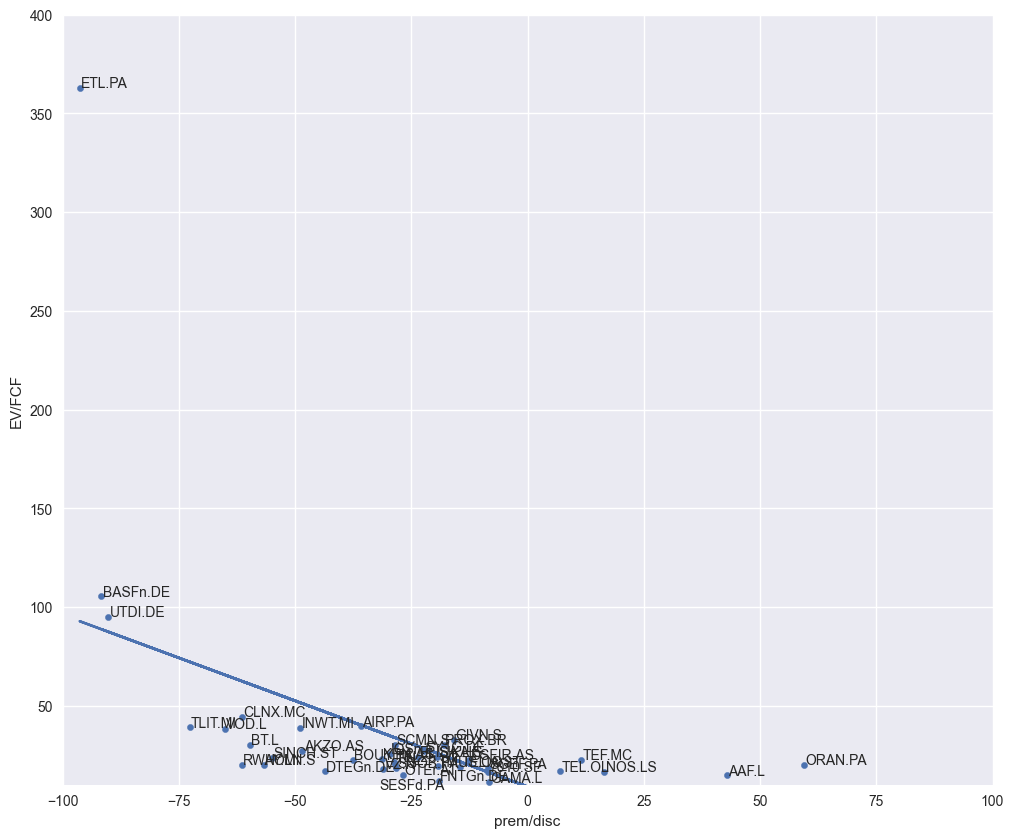

In [30]:
ax1 = peers.plot.scatter(x='prem/disc',y='EV/FCF',figsize=(12,10))


for i, ric in enumerate(peers['RIC']):
    if not pd.isnull(peers['prem/disc'][i]):
        if not pd.isnull(peers['EV/FCF'][i]):
            ax1.set_ylim(10,400)
            ax1.set_xlim(-100, 100)
            if not ric=='ILD.PA':
                ax1.text(x=peers['prem/disc'][i]+0.3,y=peers['EV/FCF'][i]+0.3,s=peers['RIC'][i])

X, Y = peers['prem/disc'].values.reshape(-1,1), peers['EV/FCF'].values.reshape(-1,1)
ax1.plot(X, LinearRegression().fit(X, Y).predict(X))

<a id='clustering'></a>
### Clustering

Now we can extend our relative valuation study to try to group companies into clusters that are similar. We saw that there there seemed to be a steep negative relationship between our two variables from the linear regression. But there are other - perhaps more useful - ways of classifying groups of observations. For example, we can ask do our observations that have very high EV/FCF multiples really belong in the same group as those observations that have low or more reasonable EV/FCF? Thankfully we can answer these types of question using generic techniques that one can apply to classifying any data. The key here is it is unsupervised - that is - we are not labelling the classifications - the clustering algorithm is generating them form the observed data. There are many ways of doing this - for brevity we will look at two, KMeans clustering and Gaussian Mixture Models which are popular in the literature. We have tried to visually limit the impact of outliers through guille and tried to focus on the bulk of the distribution. As we progress lets formally remove outliers and use this as the main body for our analysis.

In [31]:
exoutlier = peers[(peers['prem/disc'] < 50) & (peers['EV/FCF'] < 55)]
X = exoutlier[['prem/disc','EV/FCF']].values

#### KMeans Clustering

Firstly we need to try to determine the optimal amount of clusters to use so we simply conduct the KMeans analysis 10 times and then we graph the inertia_ property which tells us that probably around 2 or 3 clusters or where the elbow is is the optimal number of clusters to use. We then use n_clusters = 3 to generate the Kmeans classification and plot it.

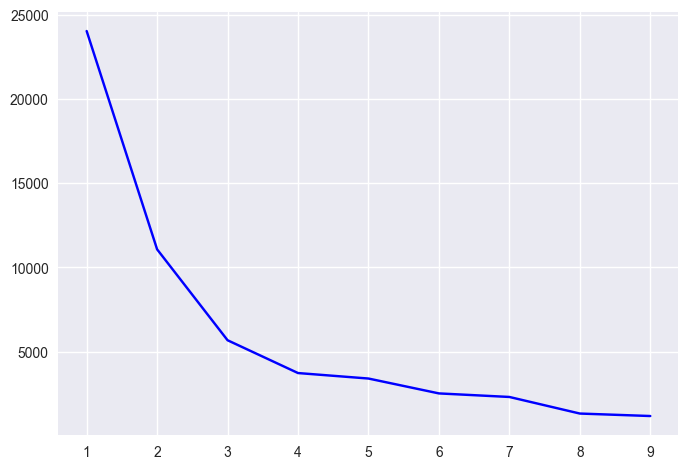

In [32]:
inertia = []
K = range(1,10)
for k in K:
    km = KMeans(n_clusters=k)
    km.fit(X)
    inertia.append(km.inertia_)

plt.plot(K, inertia, 'bx-')

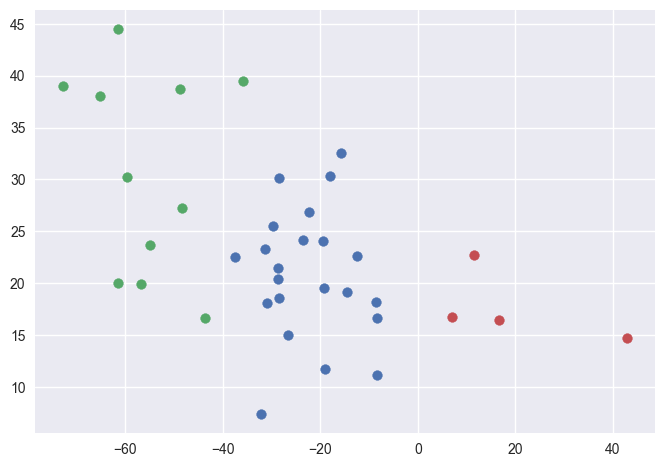

In [33]:
km = KMeans(n_clusters=3)
km.fit(X)
pred =km.predict(X)
clusters = unique(pred)
for cluster in clusters:
    row = where(pred == cluster)
    plt.scatter(X[row, 0], X[row, 1])
plt.show()

#### Gaussian Mixture Models

In the same way we start with a cluster size of 3 and then fit our data, then we generate predictions of cluster for each data point then plot each of the cluster groupings. 

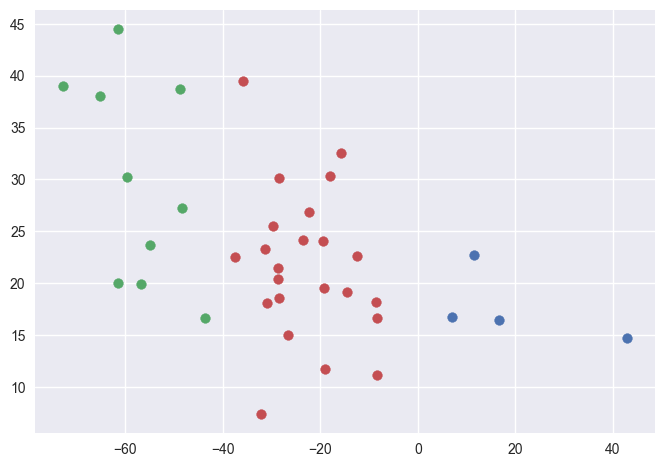

In [34]:
model = GaussianMixture(n_components=3)
model.fit(X)
pred = model.predict(X)
clusters = unique(pred)
for cluster in clusters:
    row = where(pred == cluster)
    plt.scatter(X[row, 0], X[row, 1])
plt.show()

In terms of classification - in our example I believe the simple linear regression works rather well, however, I also see some merit in the groupings generated by KMeans with 3 clusters - though there are also merits to the classification generated by the Gaussian Mixture Model. I suppose which to use depends on your use case but I hope you can use these techniques to generate further information for your 'quantamental' analyses.

<a id='summary'></a>
### Summary

In this article we have covered how to download various fundamental data (Income Statement, Cashflow Statement and Balance Sheet) that are critical for analyst workflows - using our new and improved LSEG Company Fundamentals content. We then looked at how to get at the different types of estimate data we provide, Company Guidance, Analyst Estimates, Consensus Estimates and Starmine® Smart Estimates. We showed how you can monitor changes in these critical metrics and how to chart them against instrument prices as well as access our expanded industry-specific metrics.

We then applied this knowledge by conducting a Discounted Cashflow for an indiviual company. We then scaled this up to calculate DCF-derived model prices for all the peers of a company. We visualised this as a relative valuation in a scatterplot and generated a simple linear regression line to see how that fit. Often linear regression models don't really fit data that well (though in our case it was reasonable) - so finally we went a step further and tried to classify data into groups using 2 unsupervised machine learning models, KMeans and a Gaussian Mixture Model.

**Further Resources for LSEG Data Library**

* [Overview](https://developers.lseg.com/en/api-catalog/lseg-data-platform/lseg-data-library-for-python) 
* [Quick Start ](https://developers.lseg.com/en/api-catalog/lseg-data-platform/lseg-data-library-for-python/quick-start)
* [Documentation](https://developers.lseg.com/en/api-catalog/lseg-data-platform/lseg-data-library-for-python/documentation)
* [Tutorials](https://developers.lseg.com/en/api-catalog/lseg-data-platform/lseg-data-library-for-python/tutorials)
* [Q&A Forums](https://community.developers.refinitiv.com/)

For Content Navigation in Workspace - please use the Data Item Browser Application: Type 'DIB' into Workspace Search Bar.